# Content-based Filtering Model

In [1]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime
import string

# For multilabel classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from ast import literal_eval


# For model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

Reading in the same user subset/df that is used in the CF model
- Use this because we will combine the output of the CF model with this one


In [2]:
tags = pd.read_csv("../dataset/tags_contentbased.csv")

In [3]:
tags

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,userId,movieId,tag,timestamp,un-lemmatised,glove_vec,has_glove_vec
0,0,7,266,318,260,s,2015-02-20 22:42:49,NaN,[ 0.18209 0.88297 -0.49805 0.53137 -...,True
1,1,8,267,318,115149,action,2015-02-21 15:58:30,action,[ 2.0240e-02 8.4992e-01 -7.8150e-01 -8.2769e-...,True
2,2,15,274,320,2762,twist,2006-04-25 11:33:52,twist,[-9.5859e-02 -1.7472e-01 -3.4692e-02 -3.7307e-...,True
3,3,16,275,320,2959,twist,2006-04-25 11:30:58,twist,[-9.5859e-02 -1.7472e-01 -3.4692e-02 -3.7307e-...,True
4,4,17,276,320,3996,overrate,2006-04-25 11:32:28,overrated,[ 2.8151e-01 -4.2171e-01 -3.8275e-01 1.5364e-...,True
...,...,...,...,...,...,...,...,...,...,...
50186,50186,109306,390955,138280,116797,history,2015-01-30 23:07:25,history,[ 4.5847e-02 7.4334e-02 1.5092e-02 -2.6392e-...,True
50187,50187,109307,390956,138280,116797,informatics,2015-01-30 23:07:35,informatics,[ 1.7728e-01 1.5395e-01 7.7811e-01 1.6527e-...,True
50188,50188,109308,390957,138280,116797,mathematics,2015-01-30 23:07:17,mathematics,[ 1.0033e+00 3.8874e-01 6.4312e-01 -6.8630e-...,True
50189,50189,109310,390959,138280,117871,image,2015-01-30 23:09:16,image,[ 1.1091e-02 4.8461e-01 1.9142e-02 8.3725e-...,True


In [4]:
# filtering here - the movie dataframe to only include the movies in the subset: 

In [5]:
movies = pd.read_csv("../dataset/ml-20m/movies.csv")
# Inner join on 'movieId'
filtered_movies_df = pd.merge(movies, tags[['movieId']].drop_duplicates(), on='movieId', how='inner')

# Now, filtered_movies_df will only contain the movies that are also present in tags['movieId']

In [6]:
filtered_movies_df.to_csv("../dataset/ml-20m/filtered_movies.csv")

### Content based analysis
- remove duplicates
- Semantic
    - GloVe vectors - same gloVe vectors from previous
    - POS tagging
    - NER - entities
    - Tag Frequency 
  

In [7]:
# removal of duplicates
words = tags[["tag", "glove_vec"]]
words = words.drop_duplicates()

words_ul = tags[["tag", "un-lemmatised", "glove_vec"]] # unlemmatised words
words_ul = words_ul.drop_duplicates()

def custom_parser(vec_str):
    # Remove the square brackets and split the string by spaces
    numbers = vec_str[1:-1].split()
    
    # Convert strings to floats and create a numpy array
    return np.array([float(num) for num in numbers])


words['glove_vec'] = words['glove_vec'].apply(custom_parser)
words_ul['glove_vec'] = words_ul['glove_vec'].apply(custom_parser)

In [8]:
# words['ner_label'] = ""

In [9]:
words.head(80)

,tag,glove_vec
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084..."
1,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,..."
2,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3..."
4,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648..."
5,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431..."
...,...,...
142,suicide,"[-0.31681, 0.34677, -0.5601, -0.06169, 0.11104..."
143,depress,"[0.34005, 0.62285, 0.0054628, 0.76742, 0.5336,..."
144,psychodrama,"[-0.20147, 0.14485, 0.36897, 0.51262, 0.4073, ..."
146,melancholy,"[0.056755, -0.31458, 0.62357, -0.42678, 0.4501..."


In [10]:
# manually labelling some of the words

# Dictionary for NER labels
ner_labels = {
    'childish': 'O',
    'location': 'O',
    'sibling': 'O',
    'musical': 'PROD',
    'corporation': 'O',
    'rape': 'O',
    'romance': 'PROD',
    'heartwarming': 'O',
    'character': 'O',
    'animation': 'PROD',
    'feminist': 'O',
    'cave': 'LOC',
    'time': 'O',
    'india': 'LOC',
    'friend': 'PER',
    'thailand': 'LOC',
    'cooking': 'O',
    'twitter': 'ORG',
    'photography': 'PROD',
    'drum' : 'PROD',
    'prince' : 'PER',
    'lion' : 'O',
    'favourite' : 'O',
    'groundbreaking' : 'O',
    'burlesque' : 'PROD'
    }


words['ner_label'] = words['tag'].map(ner_labels)
words

,tag,glove_vec,ner_label
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",NaN
1,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",NaN
2,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",NaN
4,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648...",NaN
5,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431...",NaN
...,...,...,...
50062,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",NaN
50110,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",NaN
50139,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",NaN
50142,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",NaN


Separate the labelled and unlabelled data

##### Named Entity Recognition


**Active Learner Model from MoDAL**
0. Set aside some of the labelled dataset as a validation set. 
    - This validation set is used to evaluate the model at each iteration.
    - Provides insights into whether training should stop.
1. Split 'words' into an initial labeled set and a larger unlabeled set.
2. Train a model on the labeled set.
3. Use the model to rank the unlabeled data based on uncertainty or informativeness.
4. Manually label the top-N most uncertain/informative samples.
5. Add these newly labeled samples to the labeled set.
6. Repeat steps 2-5 until you meet one of the stopping criteria.


MoDAL code: https://modal-python.readthedocs.io/en/latest/content/examples/query_by_committee.html

Active Learning Loop:
- Query the most informative samples.
- Label the queried samples.
- Train the model on the labeled data.
- Evaluate the model on the validation set.
- Record the performance (e.g., accuracy, F1-score).
- If the performance plateaus or starts degrading, consider stopping the active learning process.

In [11]:
# Assuming 'words' is a pandas DataFrame
split_index = int(0.8 * len(words))  # Split at 80% for training, 20% for validation

# Splitting the dataframe deterministically
train_df = words.iloc[:split_index]
valid_df = words.iloc[split_index:]

valid_df.to_csv("../dataset/to_label_ner/validation_df.csv")

In [12]:
valid_df = pd.read_csv("../dataset/to_label_ner/validation_df_done.csv")
valid_df['glove_vec'] = valid_df['glove_vec'].apply(custom_parser)

In [13]:
valid_df

,Unnamed: 0,tag,glove_vec,ner_label
0,26472,ontario,"[-0.32533, -0.18209, -0.021454, 0.16194, -0.07...",LOC
1,26484,underworld,"[-0.045434, 0.27666, -0.21188, 0.36246, -0.237...",CW
2,26486,mechanic,"[0.20201, 0.031268, 0.18269, -0.28702, 0.3244,...",O
3,26488,scientist,"[-0.55698, -0.16186, 0.31294, -0.85187, 0.8522...",PER
4,26495,training,"[0.11191, -0.51417, 0.17269, -0.56873, 0.09914...",O
...,...,...,...,...
575,50062,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",O
576,50110,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",O
577,50139,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",O
578,50142,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",O


In [14]:
words

,tag,glove_vec,ner_label
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",NaN
1,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",NaN
2,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",NaN
4,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648...",NaN
5,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431...",NaN
...,...,...,...
50062,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",NaN
50110,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",NaN
50139,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",NaN
50142,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",NaN


In [15]:
X_valid = pd.DataFrame(valid_df['glove_vec'].tolist()).to_numpy()
y_valid = valid_df['ner_label'].to_numpy()


In [20]:
# train_df['ner_label'] = train_df['ner_label'].replace(" ", np.nan)
sum(train_df['ner_label'].notna())

22

In [21]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


labels_sub = train_df
labeled_df = labels_sub[labels_sub['ner_label'].notna()]
unlabeled_df = labels_sub[labels_sub['ner_label'].isna()]
unlabeled_df = unlabeled_df.dropna(subset=['glove_vec'])

X_train = pd.DataFrame(labeled_df['glove_vec'].tolist()).to_numpy()
y_train = labeled_df['ner_label'].to_numpy()

learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_train,
    y_training=y_train
)

X_unlabeled = pd.DataFrame(unlabeled_df['glove_vec'].tolist()).to_numpy()
X_unlabeled = X_unlabeled[~np.isnan(X_unlabeled).any(axis=1)]

for iteration in range(1, 21):  # This loop will run for 3 iterations. Adjust as needed.
    if len(X_unlabeled)==0:
        print(f"All tokens are labelled")
        break
    print(f"### ITERATION {iteration} ###")

    query_idx, query_sample = learner.query(X_unlabeled, n_instances=10)
    sample_to_label = unlabeled_df.iloc[query_idx]
    sample_to_label.to_csv(f"../dataset/to_label_ner/samples_to_label_{iteration}.csv")
    
    print(f"Label samples in: ../dataset/to_label_ner/samples_to_label_{iteration}.csv")
    done = ""
    while done.lower() != "done":
        done = input("Type 'done' when you've finished labeling: ")

    annotated_samples = pd.read_csv(f"../dataset/to_label_ner/samples_to_label_{iteration}_done.csv")
    new = annotated_samples['ner_label'].values
    learner.teach(query_sample, new)

    y_pred = learner.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print(f"Validation Accuracy after iteration {iteration}:", accuracy)


### ITERATION 1 ###
Label samples in: ../dataset/to_label_ner/samples_to_label_1.csv
Type 'done' when you've finished labeling: done
Validation Accuracy after iteration 1: 0.7913793103448276
### ITERATION 2 ###
Label samples in: ../dataset/to_label_ner/samples_to_label_2.csv
Type 'done' when you've finished labeling: done
Validation Accuracy after iteration 2: 0.8137931034482758
### ITERATION 3 ###
Label samples in: ../dataset/to_label_ner/samples_to_label_3.csv
Type 'done' when you've finished labeling: done
Validation Accuracy after iteration 3: 0.8068965517241379
### ITERATION 4 ###
Label samples in: ../dataset/to_label_ner/samples_to_label_4.csv
Type 'done' when you've finished labeling: done
Validation Accuracy after iteration 4: 0.8120689655172414
### ITERATION 5 ###
Label samples in: ../dataset/to_label_ner/samples_to_label_5.csv
Type 'done' when you've finished labeling: done
Validation Accuracy after iteration 5: 0.8051724137931034
### ITERATION 6 ###
Label samples in: ../data

### Combining the labelled datasets, join to tags dataframe
- First reading in the labelled datasets then merging them together
- Then join to words dataframe

In [22]:
base_path = "../dataset/to_label_ner/"
file_prefix = "samples_to_label_"
file_suffix = "_done.csv"

dfs = []

# Loop to read files 1 through 20
for i in range(1, 21):
    file_path = f"{base_path}{file_prefix}{i}{file_suffix}"
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframes together
df_merged = pd.concat(dfs, axis=0, ignore_index=True)



,Unnamed: 0,tag,glove_vec,ner_label,Unnamed: 4
0,12756,random,[ 3.7813e-01 9.2614e-01 3.7270e-01 -6.1136e-...,O,NaN
1,23934,concert,[ 0.029852 -0.20522 -0.71844 -0.48894 -...,CW,NaN
2,12624,song,[-3.5170e-01 -2.8911e-01 1.9884e-01 -4.7476e-...,CW,NaN
3,10081,czech,[-1.8492e-01 1.5381e-01 1.2601e+00 -2.1114e-...,LOC,NaN
4,1858,wedding,[ 0.67658 0.11038 0.17131 -0.75275 -...,O,NaN
...,...,...,...,...,...
195,9014,jerusalem,[ 4.3531e-01 1.2321e+00 1.0205e+00 1.3986e-...,LOC,NaN
196,25342,pierce,[ 0.16362 -0.50971 -0.78109 -0.37825 -...,O,NaN
197,7068,trash,[ 0.29287 -0.017886 -0.16534 -0.11473 -...,O,NaN
198,25629,penthouse,[-3.3067e-02 -4.4267e-01 -3.6066e-01 -1.4896e-...,O,NaN


In [26]:
df_merged = df_merged.drop(['Unnamed: 4'], axis=1)
df_merged

,Unnamed: 0,tag,glove_vec,ner_label
0,12756,random,[ 3.7813e-01 9.2614e-01 3.7270e-01 -6.1136e-...,O
1,23934,concert,[ 0.029852 -0.20522 -0.71844 -0.48894 -...,CW
2,12624,song,[-3.5170e-01 -2.8911e-01 1.9884e-01 -4.7476e-...,CW
3,10081,czech,[-1.8492e-01 1.5381e-01 1.2601e+00 -2.1114e-...,LOC
4,1858,wedding,[ 0.67658 0.11038 0.17131 -0.75275 -...,O
...,...,...,...,...
195,9014,jerusalem,[ 4.3531e-01 1.2321e+00 1.0205e+00 1.3986e-...,LOC
196,25342,pierce,[ 0.16362 -0.50971 -0.78109 -0.37825 -...,O
197,7068,trash,[ 0.29287 -0.017886 -0.16534 -0.11473 -...,O
198,25629,penthouse,[-3.3067e-02 -4.4267e-01 -3.6066e-01 -1.4896e-...,O


In [28]:
words = words.drop(columns=['ner_label'])

In [29]:
words

,tag,glove_vec
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084..."
1,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,..."
2,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3..."
4,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648..."
5,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431..."
...,...,...
50062,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790..."
50110,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ..."
50139,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152..."
50142,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435..."


In [30]:
df_lab = df_merged[["tag", "ner_label"]]
words = words.merge(df_lab, on=['tag'], how="left")

In [34]:
words.to_csv("../dataset/to_label_ner/words.csv",index=False)

In [35]:
words['ner_label'].drop_duplicates() # need to rename for consistency

0       NaN
6        CW
23        O
60      LOC
102     PER
452    PROD
Name: ner_label, dtype: object

In [36]:
words['ner_label'] = words['ner_label'].replace('Person', 'PER')

In [37]:
words['ner_label'].drop_duplicates()

0       NaN
6        CW
23        O
60      LOC
102     PER
452    PROD
Name: ner_label, dtype: object

Testing the join:

In [38]:
words[words['tag'] == 'poker']

,tag,glove_vec,ner_label
535,poker,"[0.42254, 0.24923, -0.15362, -0.73099, 0.19908...",NaN


Converting the training data to a readable type by SpaCy model

In [39]:
t = words[words['ner_label'].isna() == False]
len(t)

200

In [40]:
t[["tag", "ner_label"]].to_csv("here.csv")

Merging t and valid_df to increase the size of the training dataset
taking 50% of valid_df for training

In [41]:
# Sample 70% of valid_df for training
sampled_valid_df_train = valid_df.sample(frac=0.7)

# The other 30% for testing
sampled_valid_df_test = valid_df.drop(sampled_valid_df_train.index)

# Merge or concatenate 't' dataframe with the training half of 'valid_df'
combined_df_train = pd.concat([t, sampled_valid_df_train], ignore_index=True)

t = combined_df_train

**Train spaCy NER model on manual labels - Custom NER model**

ref = https://towardsdatascience.com/train-ner-with-custom-training-data-using-spacy-525ce748fab7

Define the variables required for the training model to be processed.

- Model is a pre-trained one and is fine-tuned on my labels
    - Add new entity labels to NER component

In [44]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 6.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [42]:
from __future__ import unicode_literals, print_function

import random
from pathlib import Path
import spacy
from tqdm import tqdm


input_data = list(zip(t['tag'], t['ner_label']))

TRAIN_DATA = [(word, {"entities": [(0, len(word), label)]}) for word, label in input_data]



In [45]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
from pathlib import Path
import random
from tqdm import tqdm
import spacy_lookups_data

model = "en_core_web_md"

output_dir=Path("../dataset/ner_output")
n_iter = 100


# Load the model
if model is not None:
    nlp = spacy.load(model)
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')
    print("Created blank 'en' model")

# Check for NER pipe
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe('ner')

# Add new entity labels to entity recognizer
for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

# Get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.create_optimizer()  # continue training on existing model
    
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        
        # Data partitioning with minibatch
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        
        for batch in batches:
            texts, annotations = zip(*batch)

            examples = []
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                examples.append(Example.from_dict(doc, annotations[i]))

            nlp.update(examples, drop=0.5, sgd=optimizer, losses=losses)
        print("Iteration {}, Losses {}".format(itn + 1, losses))

if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)


Loaded model 'en_core_web_md'
Iteration 1, Losses {'ner': 422.6617907359614}
Iteration 2, Losses {'ner': 247.4135676920996}
Iteration 3, Losses {'ner': 233.9982915611472}
Iteration 4, Losses {'ner': 209.21005214694014}
Iteration 5, Losses {'ner': 209.36362706686486}
Iteration 6, Losses {'ner': 183.26999039935254}
Iteration 7, Losses {'ner': 176.7985747557163}
Iteration 8, Losses {'ner': 167.07425810366433}
Iteration 9, Losses {'ner': 163.42062955976098}
Iteration 10, Losses {'ner': 135.64236977750815}
Iteration 11, Losses {'ner': 128.86931058430733}
Iteration 12, Losses {'ner': 120.83931449085503}
Iteration 13, Losses {'ner': 113.51734835874157}
Iteration 14, Losses {'ner': 108.52877322344843}
Iteration 15, Losses {'ner': 107.63247987134598}
Iteration 16, Losses {'ner': 82.8958250792876}
Iteration 17, Losses {'ner': 85.04189038934966}
Iteration 18, Losses {'ner': 80.44434362227304}
Iteration 19, Losses {'ner': 62.68704302356356}
Iteration 20, Losses {'ner': 49.37958782281637}
Iteration

**Hyperparameter tuning for the NER model**
1. Dropout Rate
2. Minibatch size
3. Learning Rate
4. Number of Iterations
5. Initial model

In [46]:
import optuna

def objective(trial):
    # Define hyperparameter search space
    dropout = trial.suggest_float("dropout", 0.2, 0.8)
    compounding_start = trial.suggest_float("compounding_start", 2.0, 4.0)
    compounding_end = trial.suggest_float("compounding_end", 16.0, 32.0)
    n_iter = trial.suggest_int("n_iter", 50, 150)
    
    nlp = spacy.load(model) if model else spacy.blank('en')

    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe('ner')

    for _, annotations in TRAIN_DATA:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.create_optimizer()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            batches = minibatch(TRAIN_DATA, size=compounding(compounding_start, compounding_end, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
                nlp.update(examples, drop=dropout, sgd=optimizer, losses=losses)

    # Evaluation method
    train_tags = {item[0] for item in TRAIN_DATA}
    validation_data = valid_df[~valid_df['tag'].isin(train_tags)]
    total_predictions = 0
    correct_predictions = 0
    for _, row in validation_data.iterrows():
        doc = nlp(row['tag'])
        if doc.ents:
            predicted_label = doc.ents[0].label_
            if predicted_label == row['ner_label']:
                correct_predictions += 1
        else:
            if row['ner_label'] == 'O':
                correct_predictions += 1
        total_predictions += 1
    accuracy = correct_predictions / total_predictions

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2024-09-03 00:31:32,745] A new study created in memory with name: no-name-3a573ce2-a58f-42f4-93d9-876b315ba492
[I 2024-09-03 00:36:24,316] Trial 0 finished with value: 0.764367816091954 and parameters: {'dropout': 0.5739694415334561, 'compounding_start': 2.0841332606731973, 'compounding_end': 28.884537649220285, 'n_iter': 108}. Best is trial 0 with value: 0.764367816091954.
[I 2024-09-03 00:38:20,993] Trial 1 finished with value: 0.7988505747126436 and parameters: {'dropout': 0.5562659598253016, 'compounding_start': 3.1614213290371147, 'compounding_end': 26.7719345870495, 'n_iter': 60}. Best is trial 1 with value: 0.7988505747126436.
[I 2024-09-03 00:42:30,867] Trial 2 finished with value: 0.7816091954022989 and parameters: {'dropout': 0.727955302185287, 'compounding_start': 3.68977165516909, 'compounding_end': 21.110094861565415, 'n_iter': 146}. Best is trial 1 with value: 0.7988505747126436.
[I 2024-09-03 00:49:08,927] Trial 3 finished with value: 0.7183908045977011 and parameters

Best trial:
Value: 0.8160919540229885
Params: 
dropout: 0.5069418893315567
compounding_start: 3.5465715134131166
compounding_end: 16.57240868898037
n_iter: 114


Best trial:
Value: 0.8113207547169812
Params: 
dropout: 0.7481416541082628
compounding_start: 2.5633153390206718
compounding_end: 18.15885091048632
n_iter: 69

### Results of pretrain

ner loss = 2 from initial ner loss of 265



Checking if the model saved in the directory

In [47]:
files_in_directory = list(output_dir.iterdir())
for file in files_in_directory:
    print(file)

../dataset/ner_output/lemmatizer
../dataset/ner_output/ner
../dataset/ner_output/tokenizer
../dataset/ner_output/attribute_ruler
../dataset/ner_output/parser
../dataset/ner_output/vocab
../dataset/ner_output/config.cfg
../dataset/ner_output/tok2vec
../dataset/ner_output/tagger
../dataset/ner_output/meta.json
../dataset/ner_output/senter


**testing the trained model on validation set**
- Check that the same words aren't in the TRAIN_DATA 
- Then, record the accuracy 

In [48]:
valid_df 

,Unnamed: 0,tag,glove_vec,ner_label
0,26472,ontario,"[-0.32533, -0.18209, -0.021454, 0.16194, -0.07...",LOC
1,26484,underworld,"[-0.045434, 0.27666, -0.21188, 0.36246, -0.237...",CW
2,26486,mechanic,"[0.20201, 0.031268, 0.18269, -0.28702, 0.3244,...",O
3,26488,scientist,"[-0.55698, -0.16186, 0.31294, -0.85187, 0.8522...",PER
4,26495,training,"[0.11191, -0.51417, 0.17269, -0.56873, 0.09914...",O
...,...,...,...,...
575,50062,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",O
576,50110,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",O
577,50139,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",O
578,50142,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",O


In [49]:
for text, _ in TRAIN_DATA:
    doc = nlp(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])

Entities [('lottery', 'O')]
Entities [('engineer', 'PER')]
Entities [('narrator', 'O')]
Entities [('special', 'O')]
Entities [('protection', 'O')]
Entities [('unorthodox', 'O')]
Entities [('score', 'O')]
Entities [('brooch', 'O')]
Entities [('tightrope', 'O')]
Entities [('con', 'O')]
Entities [('hbomb', 'O')]
Entities [('erotism', 'O')]
Entities [('medieval', 'O')]
Entities [('cowboy', 'PER')]
Entities [('deaf', 'O')]
Entities [('stylish', 'O')]
Entities [('vatican', 'O')]
Entities [('literary', 'O')]
Entities [('doubledealing', 'O')]
Entities [('senseless', 'O')]
Entities [('tomb', 'O')]
Entities [('panoramic', 'O')]
Entities [('counterespionage', 'O')]
Entities [('piano', 'PROD')]
Entities [('unfinished', 'O')]
Entities [('grace', 'O')]
Entities [('avant-garde', 'CW')]
Entities [('cosmic', 'O')]
Entities [('respect', 'O')]
Entities [('democracy', 'O')]
Entities [('alienation', 'O')]
Entities [('wander', 'O')]
Entities [('misunderstood', 'O')]
Entities [('repeat', 'O')]
Entities [('tr

Entities [('feel', 'O')]
Entities [('dick', 'PER')]
Entities [('organ', 'PROD')]
Entities [('toon', 'O')]
Entities [('malik', 'PER')]
Entities [('rabbi', 'O')]
Entities [('scout', 'O')]
Entities [('pygmalion', 'PER')]
Entities [('symbolic', 'O')]
Entities [('beauty', 'CW')]
Entities [('himalaya', 'LOC')]
Entities [('giza', 'LOC')]
Entities [('humanism', 'O')]
Entities [('underground', 'LOC')]
Entities [('travelogue', 'CW')]
Entities [('originality', 'O')]
Entities [('dull', 'O')]
Entities [('dancer', 'PER')]
Entities [('tropical', 'O')]
Entities [('alabama', 'LOC')]
Entities [('definitive', 'O')]
Entities [('beef', 'O')]
Entities [('radical', 'O')]
Entities [('article', 'O')]
Entities [('darwin', 'PER')]
Entities [('fascinate', 'O')]
Entities [('gandhi', 'LOC')]
Entities [('warlord', 'O')]
Entities [('cruise', 'O')]
Entities [('lawsuit', 'O')]
Entities [('university', 'O')]
Entities [('epic', 'O')]
Entities [('shadow', 'O')]
Entities [('masculine', 'O')]
Entities [('paratrooper', 'O')]

In [50]:
# Load the trained model
if output_dir:
    print("Loading from", output_dir)
    nlp = spacy.load(output_dir)

# Extract tags from valid_df that are not in the training data
train_tags = {item[0] for item in TRAIN_DATA}
validation_data = valid_df[~valid_df['tag'].isin(train_tags)]

# Initialize counters for total and correct predictions
total_predictions = 0
correct_predictions = 0

# Iterate through the validation data and compare predictions with actual labels
for _, row in validation_data.iterrows():
    doc = nlp(row['tag'])
    
    # Check if there's an entity prediction and if it matches the label
    if doc.ents:
        predicted_label = doc.ents[0].label_
        if predicted_label == row['ner_label']:
            correct_predictions += 1
    else:
        if row['ner_label'] == 'O':  # 'O' is typically used for "Outside any entity"
            correct_predictions += 1
    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions * 100
print(f"Accuracy on validation data: {accuracy:.2f}%")


Loading from ../dataset/ner_output
Accuracy on validation data: 80.46%


In [51]:
# check for nan values and drop
print(words['tag'].isna().sum())

words = words.dropna(subset=['tag'])


1


In [52]:
### Loading the model and running on the rest of the words
model_path = "../dataset/ner_output/"
nlp = spacy.load(model_path)

def get_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply the model to the 'tag' column
words['ner_model'] = words['tag'].apply(get_entities)

/var/folders/tk/x3sjpph95kz4ghcssq1py2zc0000gn/T/ipykernel_68855/3238962201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words['ner_model'] = words['tag'].apply(get_entities)


### POS Tagging


Get the un-lemmatised version of the tags

In [53]:
words_ul

,tag,un-lemmatised,glove_vec
0,s,NaN,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084..."
1,action,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,..."
2,twist,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3..."
4,overrate,overrated,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648..."
5,violent,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431..."
...,...,...,...
50110,static,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ..."
50139,repeat,repeating,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152..."
50142,seal,seals,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435..."
50176,counterespionage,counterespionage,"[0.11309, -0.8528, -0.25529, 0.02635, -0.30105..."


In [54]:
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your words dataframe
# (assuming you already have it loaded; if not, adjust the loading method)
# words = pd.read_csv("path_to_your_dataframe.csv")

# Load Penn Treebank dataset
nltk.download("treebank")
from nltk.corpus import treebank

# Extract words from Penn Treebank
ptb_words = set(word for word, _ in treebank.tagged_words())

# Split words into train, test, and validation sets (80%, 10%, 10%)
all_words = list(ptb_words)
train_words, temp_words = train_test_split(all_words, test_size=0.2, random_state=42)
test_words, val_words = train_test_split(temp_words, test_size=0.5, random_state=42)

# Check percentage of words from your dataframe covered by Penn Treebank
your_words = set(words_ul['un-lemmatised'])
covered_words = your_words.intersection(ptb_words)
coverage_percentage = (len(covered_words) / len(your_words)) * 100

print(f"Percentage of words covered by Penn Treebank: {coverage_percentage:.2f}%")


[nltk_data] Downloading package treebank to /Users/jiayi/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


Percentage of words covered by Penn Treebank: 25.84%


In [55]:
import nltk
from nltk.corpus import brown
nltk.download('brown')
brown_tagged_words = brown.tagged_words(categories='news')  # You can choose a specific category or use all
brown_words, brown_tags = zip(*brown_tagged_words)

from sklearn.model_selection import train_test_split

# Splitting into train and temporary set (80/20)
train_temp, test_set = train_test_split(list(zip(brown_words, brown_tags)), test_size=0.2, random_state=42)

# Splitting the temporary set into test and validation (50/50)
train_set, valid_set = train_test_split(train_temp, test_size=0.5, random_state=42)


[nltk_data] Downloading package brown to /Users/jiayi/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Running this again however with a bigger set of words we get:
- by just reading in the tags_full, then renaming the dataframes in above code blocks - saves repetition of code
- need to remove duplicates 

In [56]:
words_ul

,tag,un-lemmatised,glove_vec
0,s,NaN,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084..."
1,action,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,..."
2,twist,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3..."
4,overrate,overrated,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648..."
5,violent,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431..."
...,...,...,...
50110,static,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ..."
50139,repeat,repeating,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152..."
50142,seal,seals,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435..."
50176,counterespionage,counterespionage,"[0.11309, -0.8528, -0.25529, 0.02635, -0.30105..."


### Applying spaCy POS tagging

In [61]:
import spacy
import pandas as pd

# Initialize spaCy model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")



# Function to get POS tags
def get_pos_tag(word):
    word = str(word)
    doc = nlp(word)
    return doc[0].pos_ if doc else None

# Apply function to DataFrame
words_ul["POS"] = words_ul["un-lemmatised"].apply(get_pos_tag)

print(words_ul)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
                    tag     un-lemmatised  \
0                     s               NaN   
1                action            action   
2                 twist             twist   
4              overrate         overrated   
5               violent           violent   
...                 ...               ...   
50110            static            static   
50139            repeat         repeating   
50142              seal             seals   
50176  counterespionage  counterespionage   
50189             image             image   

                                               glove_vec    POS  
0      [0.18209, 0.88297, -0.49805, 0.53137, -0.36084...  PROPN  
1      [0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...   NOUN  
2      [-0.095859, -0.17472, -0.034692, -0.37307, 0.3...   NOUN  
4    

In [62]:
words_ul

,tag,un-lemmatised,glove_vec,POS
0,s,NaN,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",PROPN
1,action,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",NOUN
2,twist,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",NOUN
4,overrate,overrated,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648...",VERB
5,violent,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431...",ADJ
...,...,...,...,...
50110,static,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",NOUN
50139,repeat,repeating,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",VERB
50142,seal,seals,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",NOUN
50176,counterespionage,counterespionage,"[0.11309, -0.8528, -0.25529, 0.02635, -0.30105...",NOUN


#### Evaluating results of POS Tagging - Manual

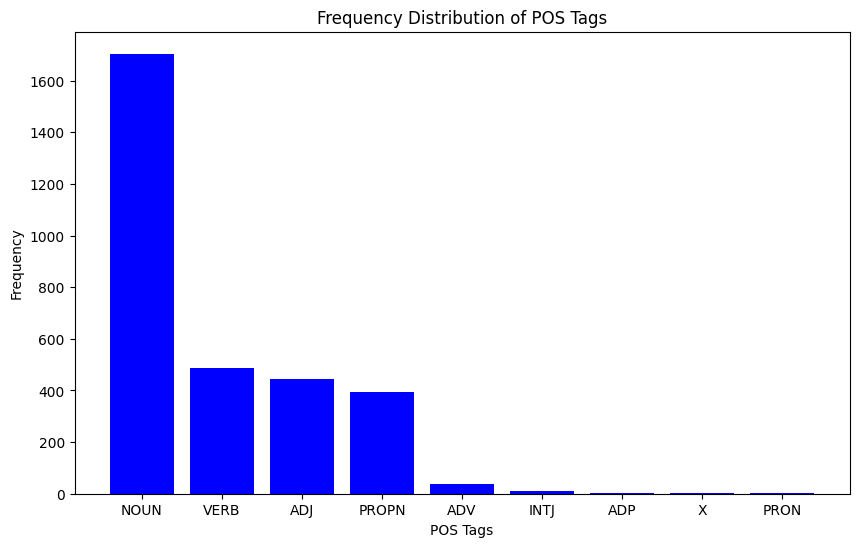

In [63]:
import matplotlib.pyplot as plt

# Count the frequency of each unique POS tag
pos_count = words_ul['POS'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(pos_count.index, pos_count.values, color='blue')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of POS Tags')
plt.show()

In [64]:
words_ul[words_ul['POS'] == 'INTJ']

,tag,un-lemmatised,glove_vec,POS
1828,s,ss,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",INTJ
2688,portland,portland,"[-0.67776, 0.0077348, -0.48764, -0.44258, 0.09...",INTJ
8736,ok,ok,"[0.30087, 0.47824, 0.54891, 0.033704, 0.14233,...",INTJ
10540,orc,orc,"[0.16322, 0.1405, -0.070897, 0.041023, 0.66704...",INTJ
10812,like,like,"[0.25527, 0.33678, -0.52359, -0.24037, 0.10562...",INTJ
18451,wy,wy,"[-0.59006, -0.57603, 0.26084, -0.11541, -0.133...",INTJ
23646,playwright,playwright,"[-0.0093478, 0.59843, -0.28273, -0.45411, 0.00...",INTJ
26339,unfaithfulness,unfaithfulness,"[0.24544, 0.20927, 0.48207, 0.093218, -0.61773...",INTJ
33773,hello,hello,"[0.26609, 0.21821, -0.10996, -0.48408, -0.1118...",INTJ
41891,goodness,goodness,"[0.46102, 0.17175, 0.64266, 0.56388, -0.79617,...",INTJ


In [65]:
words_ul[words_ul['POS'] == 'X']

,tag,un-lemmatised,glove_vec,POS
8707,etc,etc,"[0.491, 0.31059, 0.43001, 0.512, 0.1349, -0.37...",X
10574,super,super,"[-0.66806, 0.7057, -1.6854, 0.098448, -0.05147...",X


In [ ]:
words_ul[["tag", "POS"]].head(20)

Joining the words_ul back to the words dataframe

In [66]:
words

,tag,glove_vec,ner_label,ner_model
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",NaN,"[(s, O)]"
1,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",NaN,"[(action, O)]"
2,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",NaN,"[(twist, O)]"
3,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648...",NaN,"[(overrate, O)]"
4,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431...",NaN,"[(violent, O)]"
...,...,...,...,...
2894,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",NaN,"[(newspaper, O)]"
2895,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",NaN,"[(static, O)]"
2896,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",NaN,"[(repeat, O)]"
2897,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",NaN,"[(seal, O)]"


In [67]:
words_ul = words_ul.drop(columns=['un-lemmatised', 'glove_vec'])
words_ul

In [68]:
words_merge = words.merge(words_ul, on=['tag'], how='inner')
words_merge

In [69]:
words = words_merge

### Tag Frequency
- Combine with semantic - glove vec representation
- use the 'tags' dataframe -> this contains all the duplicates etc


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


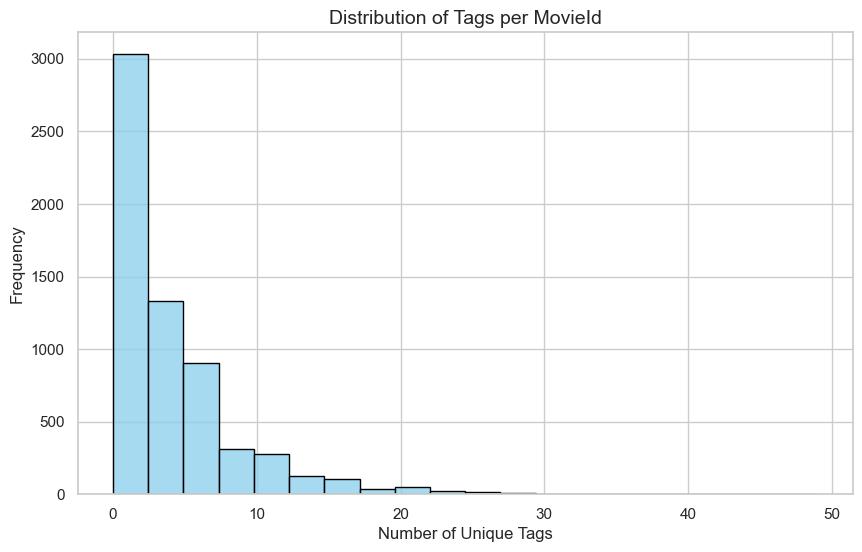

In [73]:
tags_per_movie = tags.groupby('movieId')['tag'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(tags_per_movie, bins=20, kde=False, color='skyblue', edgecolor='black')
plt.xlabel('Number of Unique Tags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Tags per MovieId', fontsize=14)
plt.show()


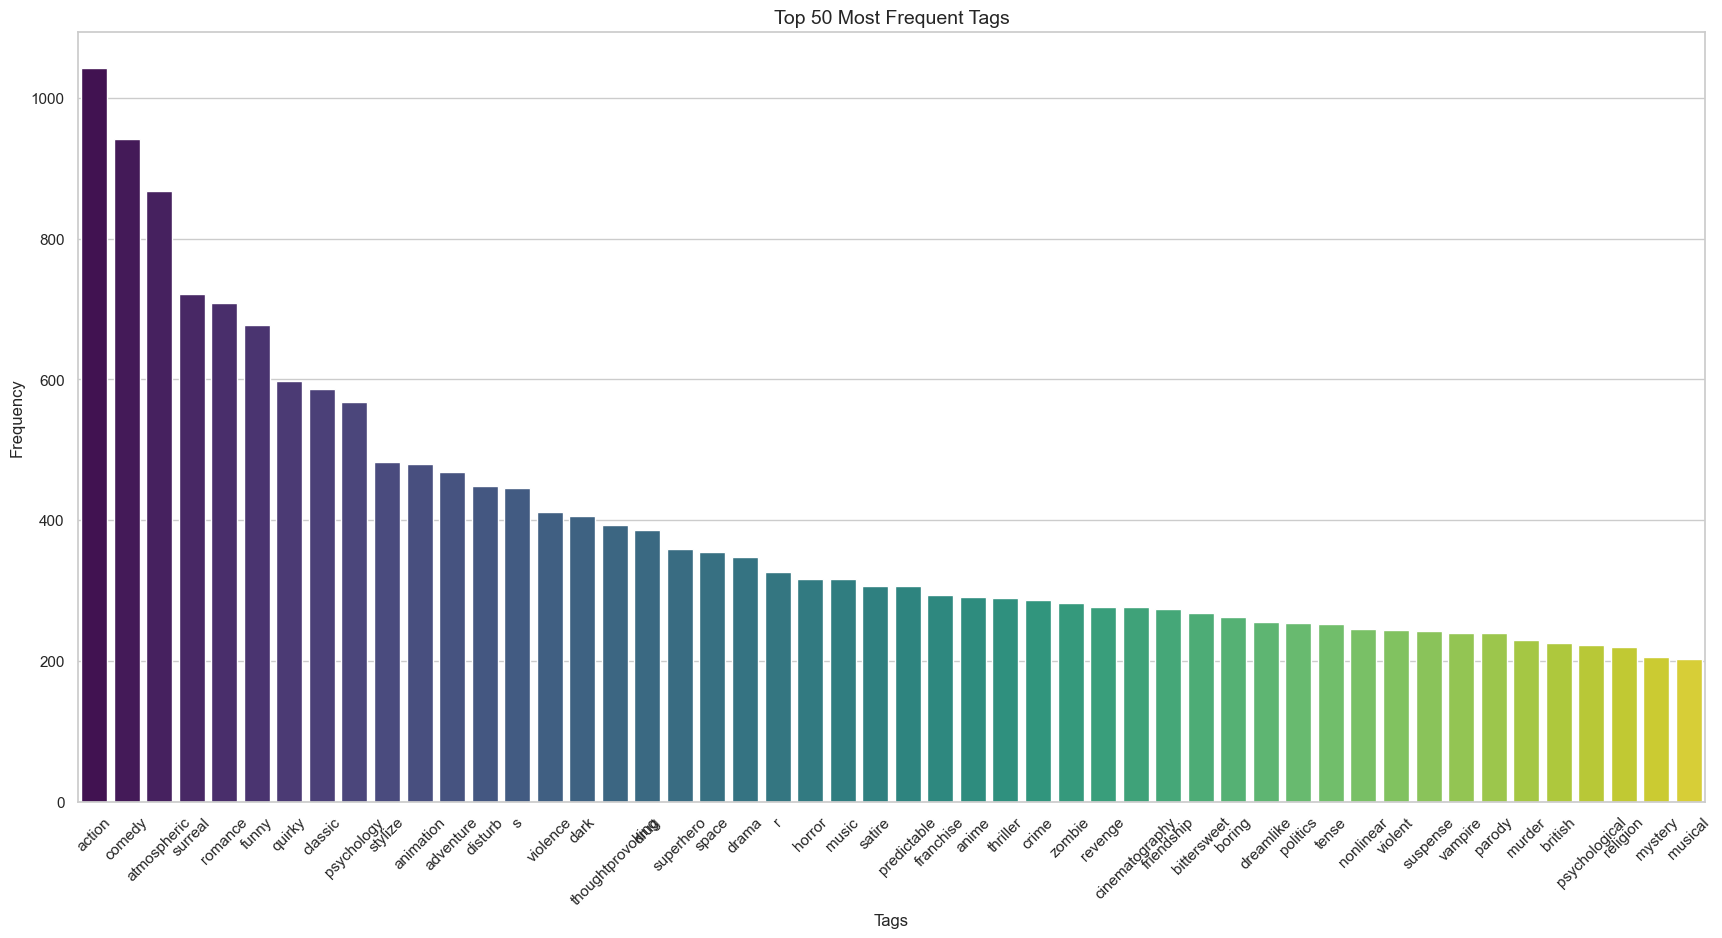

In [74]:
tag_distribution = tags['tag'].value_counts()

plt.figure(figsize=(21, 10))
sns.barplot(x=tag_distribution.index[:50], y=tag_distribution.values[:50], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel('Tags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Top 50 Most Frequent Tags', fontsize=14)
plt.show()


**Semantic Clustering**

In [75]:
tag_clusters = pd.read_csv("../dataset/tag_clusters.csv")
tag_clusters

,Unnamed: 0,tag,cluster
0,0,s,104
1,1,end,104
2,2,reverse,104
3,3,disaster,104
4,4,future,104
...,...,...,...
2894,2894,strongman,156
2895,2895,pacifist,126
2896,2896,piracy,186
2897,2897,pauli,112


### Unsupervised Word Sense Disambiguation 


context vector from CA model

Joining the context vector to tags

In [78]:
df_cv

,movieId,imdbId,tmdbId,title,genres,imdb_syn,tmdb_syn,summarized_syn,summarized_syn_cleaned,summarized_syn_tokens,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,weighted_cbow_synopsis,final_context_vector
0,1,114709,862,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",A little boy named Andy loves to be in his roo...,"Led by Woody, Andy's toys live happily in his ...",a little boy name andy love to be in room play...,"[little, boy, andy, love, room, play, toy, esp...","[a, little, boy, name, andy, love, to, be, in,...",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,113497,8844,Jumanji (1995),"[Adventure, Children, Fantasy]","Jumanji, one of the most unique--and dangerous...",When siblings Judy and Peter discover an encha...,jumanji one of the most uniqueand dangerousboa...,"[jumanji, uniqueand, dangerousboard, game, fal...","[jumanji, one, of, the, most, uniqueand, dange...",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,4,114885,31357,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",This story based on the best selling novel by ...,"Cheated on, mistreated and stepped on, the wom...",this story base on the best sell novel by terr...,"[story, base, best, sell, novel, terry, mcmill...","[this, story, base, on, the, best, sell, novel...",...,0,0,0,1,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5,113041,11862,Father of the Bride Part II (1995),[Comedy],"In this sequel to ""Father of the Bride"", Georg...",Just when George Banks has recovered from his ...,in this sequel to father of the bride george b...,"[sequel, father, bride, george, bank, accept, ...","[in, this, sequel, to, father, of, the, bride,...",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6,113277,949,Heat (1995),"[Action, Crime, Thriller]",Hunters and their prey--Neil and his professio...,Obsessive master thief Neil McCauley leads a t...,hunter and preyneil and professional criminal ...,"[hunter, preyneil, professional, criminal, cre...","[hunter, and, preyneil, and, professional, cri...",...,0,0,0,0,0,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,130856,494826,48376,Severe Clear (2010),"[Comedy, Documentary]",None,Severe Clear is a film based on the memoirs of...,severe clear be a film base on the memoir of f...,"[severe, clear, film, base, memoir, lieutenant...","[severe, clear, be, a, film, base, on, the, me...",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6179,130958,143338,78402,Killer Crocodile (1989),[Horror],None,A group of environmentalists arrives at a fara...,a group of environmentalist arrives at a faraw...,"[group, environmentalist, arrives, faraway, tr...","[a, group, of, environmentalist, arrives, at, ...",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6180,130984,208423,317168,Santo vs. las lobas (1976),"[Action, Fantasy, Horror]",None,Also known as Santo vs. the She-Wolves,also know as santo v the shewolves,"[know, santo, v, shewolves]","[also, know, as, santo, v, the, shewolves]",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6181,131011,69109,79572,Execution Squad (1972),"[Crime, Drama]",None,Bertone is a moderately honest homicide cop. U...,bertone be a moderately honest homicide cop be...,"[bertone, moderately, honest, homicide, cop, e...","[bertone, be, a, moderately, honest, homicide,...",...,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0

In [79]:
# joining on movieId


tag_cv = tags.merge(df_cv[['movieId', 'final_context_vector']], on='movieId', how='inner')

# Now, 'tag_cv' will contain all columns from 'tags' and 'final_context_vector' from 'df_cv',
# joined on 'movieId'.


In [80]:
tag_cv

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,userId,movieId,tag,timestamp,un-lemmatised,glove_vec,has_glove_vec,final_context_vector
0,0,7,266,318,260,s,2015-02-20 22:42:49,NaN,[ 0.18209 0.88297 -0.49805 0.53137 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,52,98,1584,964,260,action,2010-05-30 03:36:40,action,[ 2.0240e-02 8.4992e-01 -7.8150e-01 -8.2769e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,53,99,1585,964,260,adventure,2010-05-30 03:36:37,adventure,[ 0.094151 0.49795 -0.87618 -0.66309 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,54,100,1586,964,260,atmospheric,2010-05-30 03:36:38,atmospheric,[ 0.13512 -0.23763 -0.1364 -0.25487 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,55,104,1590,964,260,stylize,2010-05-30 03:36:32,stylized,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
49912,50146,109241,390890,138280,108981,sexuality,2014-02-14 21:49:07,sexuality,[ 2.7006e-01 3.4214e-01 4.9813e-01 -4.3149e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49913,50176,109289,390938,138280,112940,counterespionage,2014-12-27 18:19:58,counterespionage,[ 0.11309 -0.8528 -0.25529 0.02635 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49914,50177,109290,390939,138280,112940,slow,2014-12-27 18:20:04,slow,[ 0.37381 0.017462 -0.77856 0.35216 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49915,50189,109310,390959,138280,117871,image,2015-01-30 23:09:16,image,[ 1.1091e-02 4.8461e-01 1.9142e-02 8.3725e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [81]:
tag_cv.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'userId', 'movieId',
       'tag', 'timestamp', 'un-lemmatised', 'glove_vec', 'has_glove_vec',
       'final_context_vector'],
      dtype='object')

Result from the join = 47942 rows
Previous rows in tags = 48220

- The movies that didn't exist after applying the tmdb API is the cause of this result


Performing Unsupervised WSD

In [83]:
import numpy as np

def get_glove(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    return embeddings_index

path_to_glove_file = "../pretrain_model/glove.6B/glove.6B.200d.txt"
glove_vec = get_glove(path_to_glove_file)


In [84]:
import ast
import numpy as np
import pandas as pd

def safe_literal_eval(x):
    try:
        return np.array(ast.literal_eval(x))
    except (ValueError, SyntaxError):
        print(f"Failed to evaluate: {x}")
        return np.array([])  # or however you want to handle failures

# Assuming tag_cv is your DataFrae

tag_cv['final_context_vector'] = tag_cv['final_context_vector'].apply(
    lambda x: safe_literal_eval(x) if isinstance(x, str) else x
)

print(tag_cv)


       Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1  userId  movieId  \
0                 0           7           266     318      260   
1                52          98          1584     964      260   
2                53          99          1585     964      260   
3                54         100          1586     964      260   
4                55         104          1590     964      260   
...             ...         ...           ...     ...      ...   
49912         50146      109241        390890  138280   108981   
49913         50176      109289        390938  138280   112940   
49914         50177      109290        390939  138280   112940   
49915         50189      109310        390959  138280   117871   
49916         50190      109311        390960  138280   117871   

                    tag            timestamp     un-lemmatised  \
0                     s  2015-02-20 22:42:49               NaN   
1                action  2010-05-30 03:36:40            action   
2        

In [77]:
import json
df_cv = pd.read_json("../dataset/df_context_vec.json")

In [85]:
import ast

tag_cv['final_context_vector'] = tag_cv['final_context_vector'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

# removing nan values in the tag_cv

tag_cv = tag_cv.dropna(subset=['tag'])


In [86]:
tag_cv

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,userId,movieId,tag,timestamp,un-lemmatised,glove_vec,has_glove_vec,final_context_vector
0,0,7,266,318,260,s,2015-02-20 22:42:49,NaN,[ 0.18209 0.88297 -0.49805 0.53137 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,52,98,1584,964,260,action,2010-05-30 03:36:40,action,[ 2.0240e-02 8.4992e-01 -7.8150e-01 -8.2769e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,53,99,1585,964,260,adventure,2010-05-30 03:36:37,adventure,[ 0.094151 0.49795 -0.87618 -0.66309 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,54,100,1586,964,260,atmospheric,2010-05-30 03:36:38,atmospheric,[ 0.13512 -0.23763 -0.1364 -0.25487 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,55,104,1590,964,260,stylize,2010-05-30 03:36:32,stylized,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
49912,50146,109241,390890,138280,108981,sexuality,2014-02-14 21:49:07,sexuality,[ 2.7006e-01 3.4214e-01 4.9813e-01 -4.3149e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49913,50176,109289,390938,138280,112940,counterespionage,2014-12-27 18:19:58,counterespionage,[ 0.11309 -0.8528 -0.25529 0.02635 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49914,50177,109290,390939,138280,112940,slow,2014-12-27 18:20:04,slow,[ 0.37381 0.017462 -0.77856 0.35216 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49915,50189,109310,390959,138280,117871,image,2015-01-30 23:09:16,image,[ 1.1091e-02 4.8461e-01 1.9142e-02 8.3725e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Reading the genre glove vec into a dictionary

In [87]:
import pickle

# Reading from file
with open('../pretrain_model/genre_glove_vec.pkl', 'rb') as f:
    genre_glove_vec = pickle.load(f)

# loaded_genre_glove_vec now contains your original dictionary


In [88]:
# loading in the movie and genre df
df_mg = pd.read_csv("../dataset/movie_genre.csv")
df_mg

,movieId,genres
0,1,"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,"['Adventure', 'Children', 'Fantasy']"
2,4,"['Comedy', 'Drama', 'Romance']"
3,5,['Comedy']
4,6,"['Action', 'Crime', 'Thriller']"
...,...,...
6178,130856,"['Comedy', 'Documentary']"
6179,130958,['Horror']
6180,130984,"['Action', 'Fantasy', 'Horror']"
6181,131011,"['Crime', 'Drama']"


In [89]:
# join to main df 'tag_cv'

tag_cv = pd.merge(tag_cv, df_mg, on='movieId')


In [90]:
tag_cv

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,userId,movieId,tag,timestamp,un-lemmatised,glove_vec,has_glove_vec,final_context_vector,genres
0,0,7,266,318,260,s,2015-02-20 22:42:49,NaN,[ 0.18209 0.88297 -0.49805 0.53137 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']"
1,52,98,1584,964,260,action,2010-05-30 03:36:40,action,[ 2.0240e-02 8.4992e-01 -7.8150e-01 -8.2769e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']"
2,53,99,1585,964,260,adventure,2010-05-30 03:36:37,adventure,[ 0.094151 0.49795 -0.87618 -0.66309 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']"
3,54,100,1586,964,260,atmospheric,2010-05-30 03:36:38,atmospheric,[ 0.13512 -0.23763 -0.1364 -0.25487 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']"
4,55,104,1590,964,260,stylize,2010-05-30 03:36:32,stylized,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']"
...,...,...,...,...,...,...,...,...,...,...,...,...
49625,50146,109241,390890,138280,108981,sexuality,2014-02-14 21:49:07,sexuality,[ 2.7006e-01 3.4214e-01 4.9813e-01 -4.3149e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Drama', 'Mystery']"
49626,50176,109289,390938,138280,112940,counterespionage,2014-12-27 18:19:58,counterespionage,[ 0.11309 -0.8528 -0.25529 0.02635 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['Thriller']
49627,50177,109290,390939,138280,112940,slow,2014-12-27 18:20:04,slow,[ 0.37381 0.017462 -0.77856 0.35216 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['Thriller']
49628,50189,109310,390959,138280,117871,image,2015-01-30 23:09:16,image,[ 1.1091e-02 4.8461e-01 1.9142e-02 8.3725e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Drama', 'War']"


### WSD using the Context Vector of Movie Synopsis and Genre GloVe vectors 

In [91]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet as wn
import pandas as pd

def get_word_senses(word):
    """Retrieve all possible senses of a word from WordNet."""
    return wn.synsets(word)

def compute_kde(x, y):
    """Compute the KDE score between two vectors."""
    kde = KernelDensity()
    kde.fit(x.reshape(-1, 1))
    log_dens = kde.score_samples(y.reshape(-1, 1))
    return np.exp(log_dens).mean()

def convert_synset_to_vector(synset, glove_vec):
    """Convert WordNet synset to GloVe vector by averaging lemma vectors."""
    lemma_names = synset.lemma_names()
    vectors = [glove_vec.get(lemma, np.zeros((200,))) for lemma in lemma_names]
    if len(vectors) == 0:
        return np.zeros((200,))
    return np.mean(vectors, axis=0)

def get_max_similarity_genre(genres, sense_vector, genre_glove_vec):
    """Find the genre with the maximum similarity."""
    max_similarity = float('-inf')
    max_genre = None
    
    for genre in genres:
        genre_vec = np.array(genre_glove_vec.get(genre, np.zeros((200,))))
        similarity = cosine_similarity(sense_vector.reshape(1, -1), genre_vec.reshape(1, -1))
        
        if similarity > max_similarity:
            max_similarity = similarity
            max_genre = genre

    return max_genre, max_similarity

def disambiguate_word_sense(row, glove_vec, genre_glove_vec):
    """Disambiguate the sense of a word using the context vector and genre."""
    word = row['tag']
    context_vector = np.array(row['final_context_vector'])
    genres = row['genres']
    
    expected_shape = 200
    if context_vector.shape != (expected_shape,):
        raise ValueError(f"Invalid shape for context_vector: {context_vector.shape}")

    senses = get_word_senses(word)
    if not senses:
        return word, 0.0
    
    max_prob = float('-inf')
    best_sense = None
    
    for sense in senses:
        sense_vector = convert_synset_to_vector(sense, glove_vec)
        
        if sense_vector.shape != (expected_shape,):
            raise ValueError(f"Invalid shape for sense_vector: {sense_vector.shape}")

        prob_density_context = compute_kde(sense_vector.reshape(-1, 1), context_vector.reshape(-1, 1))
        max_genre, prob_density_genre = get_max_similarity_genre(genres, sense_vector, genre_glove_vec)
        
        prob_density = max(prob_density_context, prob_density_genre)
        
        if prob_density > max_prob:
            max_prob = prob_density
            best_sense = sense.name()
    
    return best_sense, max_prob

# Assuming tag_cv, glove_vec, and genre_glove_vec are available
tag_cv['disambiguated_sense'], tag_cv['confidence'] = zip(*tag_cv.apply(lambda row: disambiguate_word_sense(row, glove_vec, genre_glove_vec), axis=1))


In [96]:
# tag_cv.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.2'], inplace=True)
tag_cv.to_csv("../dataset/tag_cv.csv",index=False)

Output of the WSD
- 2 additional columns: disambiguated_sense and confidence 

disambiguated_sense: This column will contain the WordNet synset that has the highest Kernel Density Estimation (KDE) score when compared to the final_context_vector for each row. The synset is a specific sense or meaning of the word (tag) in the same row.

confidence: This column will contain the KDE score for the chosen disambiguated_sense, which gives an idea of how well the sense matches the context. The higher the KDE score, the more "confident" the model is that the chosen sense is correct.

In [97]:
tag_cv

In [93]:
print(tag_cv['final_context_vector'].isna().sum())  # Count NaN values
print(tag_cv['final_context_vector'].apply(type).unique())  # Check types


0
[<class 'list'>]


In [103]:
df_wsd = tag_cv[['userId','movieId','tag','disambiguated_sense','confidence']]
df_wsd

,userId,movieId,tag,disambiguated_sense,confidence
0,318,260,s,mho.n.01,0.396197
1,964,260,action,legal_action.n.01,0.395202
2,964,260,adventure,adventure.n.01,0.394330
3,964,260,atmospheric,atmospheric.a.01,0.388486
4,964,260,stylize,stylize.v.01,0.398942
...,...,...,...,...,...
49625,138280,108981,sexuality,sex.n.04,0.370642
49626,138280,112940,counterespionage,counterespionage.n.01,0.367513
49627,138280,112940,slow,slow.v.03,0.395033
49628,138280,117871,image,trope.n.01,0.390764


In [104]:
sorted_df = df_wsd[["tag", "disambiguated_sense", "confidence"]].sort_values(by="confidence", ascending=False).head(20)

distinct_tags_df = sorted_df.drop_duplicates(subset=["tag"]).copy()
print(distinct_tags_df[["tag", "disambiguated_sense", "confidence"]])



             tag           disambiguated_sense  confidence
20064      death                    death.n.06    0.398942
33324  holocaust                holocaust.n.02    0.398942
33330       john                     john.n.02    0.398942
5290         elf  extremely_low_frequency.n.01    0.398942
5289   christmas                christmas.n.01    0.398942
20434  australia                australia.n.01    0.398942
40031    british                  british.n.01    0.398942
20433      china                    china.n.01    0.398942
5280      gothic                   gothic.n.01    0.398942
28583     greece                   greece.n.01    0.398942
33327       goth                     goth.n.02    0.398942
40044       gore                     gore.n.01    0.398942
28582    stylize                  stylize.v.01    0.398942
33315     circus                   circus.n.06    0.398942


In [105]:
df_wsd[df_wsd['tag'] == '']

,userId,movieId,tag,disambiguated_sense,confidence


### Tag Recommendation
Cascading effect by using the output of the CF model as a starting point for recommendation

1. Take in the recommendations from the CF model k x (movieId, sentiment)
2. We will use these recommendations as a lookup table on userId. 
3. The (movieId, sentiment) serves as a preliminary filter for the CB filtering process
4. For each movieId in the list of k recommendations, filter on the tags that have been applied to that movieId by other users. 
5. Compute similarity scores between the tags that have been applied to the movie with the tag of a user.
    - Done using the CB features we calculated
6. (Assuming the sentiment feature has been brought in already): use the sentiment part of the CF recommendation to refine the similar tags from step 5 -> making sure the sentiment of the tag is the same as the sentiment given from the CF movie. 
7. Tag recommendation 

#### get the recommendations (movieId, sentiment) from CF model

In [106]:
df_rec = pd.read_json('../dataset/df_rec.json', orient='split')
df_rec


,userId,recommendations,tags_movies
0,318,"[[260, 0.1389], [780, 0.1588], [1196, 0.294600...","[[260, [action, space, luke, sequel, robot, he..."
1,2274,"[[2762, 0.1212], [2959, 0.1212], [3996, 0.2166...","[[2762, [nan, enigmatic, thriller, unpredictab..."
2,3031,"[[70, -0.49810000000000004], [353, 0.25], [805...","[[70, [gore, brother, vampire, intense, nan, s..."
3,4087,"[[296, 0.0051], [805, 0.2713], [1136, 0.205000...","[[296, [action, rivet, masterpiece, drug, dial..."
4,4450,"[[1994, 0.1524], [4995, 0.20500000000000002], ...","[[1994, [thriller, ghost]], [4995, [education,..."
...,...,...,...
1547,117265,"[[47, 0.176], [50, 0.1822], [356, 0.1751], [10...","[[47, [overrate, investigation, philosophical,..."
1548,117607,"[[1257, 0.1369], [1748, 0.1617], [2916, -0.027...","[[1257, [imagination, goofy, silly, skiing, qu..."
1549,123915,"[[1, 0.1628], [22, -0.2524], [70, 0.1625], [11...","[[1, [woody, adventure, watch, buy, comedy, fa..."
1550,127468,"[[12, 0.1932], [21, 0.16040000000000001], [26,...","[[12, [vampire, gothic]], [21, [mafia, hollywo..."


In [107]:
df_rec['recommendations'] = df_rec['recommendations'].apply(lambda x: [(int(a), round(b, 4)) for a, b in x])
df_rec

,userId,recommendations,tags_movies
0,318,"[(260, 0.1389), (780, 0.1588), (1196, 0.2946),...","[[260, [action, space, luke, sequel, robot, he..."
1,2274,"[(2762, 0.1212), (2959, 0.1212), (3996, 0.2166...","[[2762, [nan, enigmatic, thriller, unpredictab..."
2,3031,"[(70, -0.4981), (353, 0.25), (805, 0.25), (487...","[[70, [gore, brother, vampire, intense, nan, s..."
3,4087,"[(296, 0.0051), (805, 0.2713), (1136, 0.205), ...","[[296, [action, rivet, masterpiece, drug, dial..."
4,4450,"[(1994, 0.1524), (4995, 0.205), (4226, 0.145),...","[[1994, [thriller, ghost]], [4995, [education,..."
...,...,...,...
1547,117265,"[(47, 0.176), (50, 0.1822), (356, 0.1751), (10...","[[47, [overrate, investigation, philosophical,..."
1548,117607,"[(1257, 0.1369), (1748, 0.1617), (2916, -0.027...","[[1257, [imagination, goofy, silly, skiing, qu..."
1549,123915,"[(1, 0.1628), (22, -0.2524), (70, 0.1625), (11...","[[1, [woody, adventure, watch, buy, comedy, fa..."
1550,127468,"[(12, 0.1932), (21, 0.1604), (26, 0.1674), (32...","[[12, [vampire, gothic]], [21, [mafia, hollywo..."


#### The (movieId, sentiment) serves as a preliminary filter for the CB filtering process 

- Provides a set of preliminary tags that the CB model can look at to refine and produce similar recommendationn

For each movieId in the list of k recommendations, filter on the tags that have been applied to that movieId by other users. 
- So for each movieId - get the tags that have been applied by other users

In [108]:
tag_cv

,userId,movieId,tag,timestamp,un-lemmatised,glove_vec,has_glove_vec,final_context_vector,genres,disambiguated_sense,confidence
0,318,260,s,2015-02-20 22:42:49,NaN,[ 0.18209 0.88297 -0.49805 0.53137 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']",mho.n.01,0.396197
1,964,260,action,2010-05-30 03:36:40,action,[ 2.0240e-02 8.4992e-01 -7.8150e-01 -8.2769e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']",legal_action.n.01,0.395202
2,964,260,adventure,2010-05-30 03:36:37,adventure,[ 0.094151 0.49795 -0.87618 -0.66309 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']",adventure.n.01,0.394330
3,964,260,atmospheric,2010-05-30 03:36:38,atmospheric,[ 0.13512 -0.23763 -0.1364 -0.25487 ...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']",atmospheric.a.01,0.388486
4,964,260,stylize,2010-05-30 03:36:32,stylized,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Adventure', 'Sci-Fi']",stylize.v.01,0.398942
...,...,...,...,...,...,...,...,...,...,...,...
49625,138280,108981,sexuality,2014-02-14 21:49:07,sexuality,[ 2.7006e-01 3.4214e-01 4.9813e-01 -4.3149e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Drama', 'Mystery']",sex.n.04,0.370642
49626,138280,112940,counterespionage,2014-12-27 18:19:58,counterespionage,[ 0.11309 -0.8528 -0.25529 0.02635 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['Thriller'],counterespionage.n.01,0.367513
49627,138280,112940,slow,2014-12-27 18:20:04,slow,[ 0.37381 0.017462 -0.77856 0.35216 -...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['Thriller'],slow.v.03,0.395033
49628,138280,117871,image,2015-01-30 23:09:16,image,[ 1.1091e-02 4.8461e-01 1.9142e-02 8.3725e-...,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['Action', 'Drama', 'War']",trope.n.01,0.390764


Merging all the content-based features into one dataframe
- for ease of lookup 

Features: 
    - GloVe vectors - same gloVe vectors from previous
    - POS tagging
    - Sentiment
    - NER - entities
    - Tag Frequency 
    - Semantic clusters
    - Word Sense Disambiguation (WSD) 

- WSD in separate dataframe (needs to be in conisderation with movieId)

WSD dataframe

In [109]:
df_wsd = tag_cv[['userId', 'movieId', 'tag', 'disambiguated_sense', 'confidence']].copy()


In [110]:
# Creating a dataframe with only the distinct tags 
dist_tags = words[['tag']].drop_duplicates().reset_index(drop=True)
dist_tags

,tag
0,s
1,action
2,twist
3,overrate
4,violent
...,...
2893,newspaper
2894,static
2895,repeat
2896,seal


In [111]:
# placing the glove_vec to the df_feat dataframe, access in the "words"
words

words['ner_label'] = words['ner_model'].apply(lambda x: x[0][1] if x else None)
words

,tag,glove_vec,ner_label,ner_model,POS
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",O,"[(s, O)]",PROPN
1,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",O,"[(s, O)]",INTJ
2,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",O,"[(action, O)]",NOUN
3,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",O,"[(twist, O)]",NOUN
4,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",O,"[(twist, O)]",NOUN
...,...,...,...,...,...
3078,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",O,"[(newspaper, O)]",NOUN
3079,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",O,"[(static, O)]",NOUN
3080,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",O,"[(repeat, O)]",VERB
3081,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",O,"[(seal, O)]",NOUN


In [112]:
# reading in the sentiment df
df_sent = pd.read_csv('../dataset/df_tag_sentiment.csv')
df_sent

,Unnamed: 0.1,Unnamed: 0,tag,sentiment_roberta,sentiment_label,sentiment_value,scaled_sentiment_value
0,0,0,s,"('neutral', 0.5123)",neutral,0.5123,0.24385
1,1,1,action,"('neutral', 0.6874)",neutral,0.6874,0.15630
2,2,2,twist,"('neutral', 0.7575)",neutral,0.7575,0.12125
3,3,3,twist,"('neutral', 0.7575)",neutral,0.7575,0.12125
4,4,4,overrate,"('neutral', 0.5669)",neutral,0.5669,0.21655
...,...,...,...,...,...,...,...
50186,50186,50186,history,"('neutral', 0.6321)",neutral,0.6321,0.18395
50187,50187,50187,informatics,"('neutral', 0.7477)",neutral,0.7477,0.12615
50188,50188,50188,mathematics,"('neutral', 0.7053)",neutral,0.7053,0.14735
50189,50189,50189,image,"('neutral', 0.7328)",neutral,0.7328,0.13360


In [113]:
df_feat = dist_tags.merge(words[['tag', 'glove_vec']], on='tag', how='left') # glove
df_feat = df_feat.merge(words[['tag', 'ner_label']], on='tag', how='left') #ner
df_feat = df_feat.merge(words[['tag', 'POS']], on='tag', how='left') # pos
df_feat = df_feat.merge(df_sent[['tag', 'sentiment_label', 'scaled_sentiment_value']], on='tag', how='left') #sentiment 


df_feat.drop_duplicates(subset=['tag'], inplace=True)
df_feat


,tag,glove_vec,ner_label,POS,sentiment_label,scaled_sentiment_value
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",O,PROPN,neutral,0.24385
3568,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",O,NOUN,neutral,0.15630
4610,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",O,NOUN,neutral,0.12125
5879,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648...",O,VERB,neutral,0.21655
6027,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431...",O,ADJ,neutral,0.25750
...,...,...,...,...,...,...
97104,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",O,NOUN,neutral,0.10295
97105,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",O,NOUN,positive,0.76810
97106,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",O,VERB,neutral,0.19360
97107,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",O,NOUN,neutral,0.17375


In [137]:
df_feat.to_json("../dataset/df_feat.json")

In [115]:
df_rec

,userId,recommendations,tags_movies
0,318,"[(260, 0.1389), (780, 0.1588), (1196, 0.2946),...","[[260, [action, space, luke, sequel, robot, he..."
1,2274,"[(2762, 0.1212), (2959, 0.1212), (3996, 0.2166...","[[2762, [nan, enigmatic, thriller, unpredictab..."
2,3031,"[(70, -0.4981), (353, 0.25), (805, 0.25), (487...","[[70, [gore, brother, vampire, intense, nan, s..."
3,4087,"[(296, 0.0051), (805, 0.2713), (1136, 0.205), ...","[[296, [action, rivet, masterpiece, drug, dial..."
4,4450,"[(1994, 0.1524), (4995, 0.205), (4226, 0.145),...","[[1994, [thriller, ghost]], [4995, [education,..."
...,...,...,...
1547,117265,"[(47, 0.176), (50, 0.1822), (356, 0.1751), (10...","[[47, [overrate, investigation, philosophical,..."
1548,117607,"[(1257, 0.1369), (1748, 0.1617), (2916, -0.027...","[[1257, [imagination, goofy, silly, skiing, qu..."
1549,123915,"[(1, 0.1628), (22, -0.2524), (70, 0.1625), (11...","[[1, [woody, adventure, watch, buy, comedy, fa..."
1550,127468,"[(12, 0.1932), (21, 0.1604), (26, 0.1674), (32...","[[12, [vampire, gothic]], [21, [mafia, hollywo..."


### Recommendations using Similarity Metric 
- We will use a blend of similarity metrics as the similarity of some features will need certain metrics over others
- For glove vectors, scaled_sentiment_value, term(tag) frequency, semantic clusters: exact match
- For POS, disambiguated_sense, sentiment_label, ner: exact  matching


**Since different similarity scores are used - we have to normalize each of the scores, then average to get final similarity score between tags**
- why? otherwise one type of similarity may dominate others causing an imbalance in the final score 

Try testing on a single user - and then evaluating the relevance of the recommendation
- then we can pilot on other users 

get_user_recommendations: function gets movieId, sentiment pairs from df_rec, AND the tags that a user has applied previously - these tags will be used to calculate similarity with other tags for the content-based filtering. 
    - In terms of additional context, considering the tag, movieId for a user provides more nuanced recommendations and can be integrated in the context-aware model 
    - The WSD serves as an additional context layer already - as the movieId is considered here 

In [116]:
df_rec

,userId,recommendations,tags_movies
0,318,"[(260, 0.1389), (780, 0.1588), (1196, 0.2946),...","[[260, [action, space, luke, sequel, robot, he..."
1,2274,"[(2762, 0.1212), (2959, 0.1212), (3996, 0.2166...","[[2762, [nan, enigmatic, thriller, unpredictab..."
2,3031,"[(70, -0.4981), (353, 0.25), (805, 0.25), (487...","[[70, [gore, brother, vampire, intense, nan, s..."
3,4087,"[(296, 0.0051), (805, 0.2713), (1136, 0.205), ...","[[296, [action, rivet, masterpiece, drug, dial..."
4,4450,"[(1994, 0.1524), (4995, 0.205), (4226, 0.145),...","[[1994, [thriller, ghost]], [4995, [education,..."
...,...,...,...
1547,117265,"[(47, 0.176), (50, 0.1822), (356, 0.1751), (10...","[[47, [overrate, investigation, philosophical,..."
1548,117607,"[(1257, 0.1369), (1748, 0.1617), (2916, -0.027...","[[1257, [imagination, goofy, silly, skiing, qu..."
1549,123915,"[(1, 0.1628), (22, -0.2524), (70, 0.1625), (11...","[[1, [woody, adventure, watch, buy, comedy, fa..."
1550,127468,"[(12, 0.1932), (21, 0.1604), (26, 0.1674), (32...","[[12, [vampire, gothic]], [21, [mafia, hollywo..."


#### Compute Individual Similarity Metrics and get user features
- NOTE: the tags recommended MUST not be the same as the user tags
For each feature set (content based features) - calculate the similarity scores between the tags given by the target user and the tags in the recommendation movieId set

1. Consolidate user features into one dataframe for efficiency of comparison 

In [117]:
def get_user_data(df_rec, tag_cv, target_userId):
    """
    Retrieve movie recommendations, user tags, and tags_movies for a target userId.

    Parameters:
        df_rec (DataFrame): The DataFrame containing userId, recommendations, and tags_movies columns.
        tag_cv (DataFrame): The DataFrame containing userId, movieId, and tags.
        target_userId (int): The userId for whom the data is to be fetched.

    Returns:
        tuple: A tuple containing three lists:
               - The first list contains recommendations (movieId, sentiment) for the target userId.
               - The second list contains tags applied by the target userId in the format (movieId, tag).
               - The third list contains tags_movies entries for the target userId in the format [(movieId, [tags...]), ...].
    """
    # Fetch movie recommendations
    recommendations = get_user_recommendations(df_rec, target_userId)
    
    # Fetch tags applied by the user
    user_tags = get_user_tags(tag_cv, target_userId)
    
    # Fetch tags_movies data for the user
    tags_movies = get_tags_movies_for_user(df_rec, target_userId)
    
    return recommendations, user_tags, tags_movies


def get_user_recommendations(df_rec, target_userId):
    filtered_df = df_rec[df_rec['userId'] == target_userId]
    if len(filtered_df) == 0:
        return []
    recommendations = filtered_df['recommendations'].iloc[0]
    return recommendations


def get_user_tags(tag_cv, target_userId):
    filtered_df = tag_cv[tag_cv['userId'] == target_userId]
    if len(filtered_df) == 0:
        return []
    user_tags = filtered_df[['movieId', 'tag']].values.tolist()
    return user_tags


def get_tags_movies_for_user(df_rec, target_userId):
    filtered_df = df_rec[df_rec['userId'] == target_userId]
    if len(filtered_df) == 0:
        return []
    tags_movies = filtered_df['tags_movies'].iloc[0]
    return tags_movies




def get_user_feature_set_and_wsd(df_feat, df_wsd, user_tags, tag_clusters, target_userId):
    """
    Fetch additional features, WSD, and TF/TF-IDF info for a list of user tags.
    
    Parameters:
        df_feat (DataFrame): The DataFrame containing features for each tag.
        df_wsd (DataFrame): The DataFrame containing WSD information.
        user_tags (list): The list containing tags applied by the user in the format (movieId, tag).
        target_userId (int): The userId for whom the WSD data is to be fetched.
        
    Returns:
        tuple: A tuple containing three DataFrames:
               - The first DataFrame contains additional features for each user tag.
               - The second DataFrame contains WSD information for the user.
               - The third DataFrame contains TF and TF-IDF information for the user tags.
    """
    # Filtering df_feat to only include rows where the tag is in user_tags
    filtered_df_feat = df_feat[df_feat['tag'].isin([tag for _, tag in user_tags])]
    
    # Filtering df_wsd to include only rows for the target_userId
    filtered_df_wsd = df_wsd[df_wsd['userId'] == target_userId]
    
    # joining the cluster to the tags

    filtered_df_feat = pd.merge(filtered_df_feat, tag_clusters, on='tag', how='inner')
    # Create a set of (movieId, tag) tuples for easier filtering
    user_tags_set = set(tuple(x) for x in user_tags)


    return filtered_df_feat, filtered_df_wsd





**Get user features**

Run here ->


In [134]:
# tag_cv.to_json('../dataset/tag_csv.json')

In [135]:
# tag_clusters.to_csv("../dataset/tag_clusters.csv")

In [136]:
# df_wsd.to_csv("../dataset/df_wsd.csv")

In [125]:
df_wsd

,userId,movieId,tag,disambiguated_sense,confidence
0,318,260,s,mho.n.01,0.396197
1,964,260,action,legal_action.n.01,0.395202
2,964,260,adventure,adventure.n.01,0.394330
3,964,260,atmospheric,atmospheric.a.01,0.388486
4,964,260,stylize,stylize.v.01,0.398942
...,...,...,...,...,...
49625,138280,108981,sexuality,sex.n.04,0.370642
49626,138280,112940,counterespionage,counterespionage.n.01,0.367513
49627,138280,112940,slow,slow.v.03,0.395033
49628,138280,117871,image,trope.n.01,0.390764


In [128]:
# Example usage
# Assuming df_rec is the DataFrame containing userId, recommendations, and tags_movies columns, and tag_cv is the DataFrame containing userId, movieId, and tags.

recommendations, user_tags, tags_movies = get_user_data(df_rec, tag_cv, 964)

print("Recommendations:", recommendations)
print("User Tags:", user_tags)
print("Tags Movies for userId 505:", tags_movies)

# Get additional features, WSD information for user_tags and userId=96
user_features, user_wsd= get_user_feature_set_and_wsd(df_feat, df_wsd,  user_tags, tag_clusters, 964)


user_features

Recommendations: [(260, 0.2438), (115149, 0.1563), (2762, 0.1212), (2959, 0.1212), (3996, 0.2166), (6016, 0.2575), (7438, 0.2575), (296, 0.0051), (805, 0.2713), (1136, 0.205)]
User Tags: [[260, 'action'], [260, 'adventure'], [260, 'atmospheric'], [260, 'stylize'], [2959, 'action'], [2959, 'atmospheric'], [2959, 'disturb'], [2959, 'philosophy'], [2959, 'psychology'], [2959, 'quirky'], [2959, 'surreal'], [2959, 'violence'], [780, 'action'], [780, 'adventure'], [780, 'aviation'], [780, 'disaster'], [780, 'humorous'], [780, 'tense'], [1196, 'action'], [1196, 'adventure'], [1196, 'classic'], [1196, 'music'], [1196, 'sequel'], [1197, 'action'], [1197, 'classic'], [1197, 'comedy'], [1197, 'funny'], [1197, 'medieval'], [1197, 'pirate'], [1197, 'quirky'], [1197, 'revenge'], [1197, 'romance'], [1197, 'torture'], [1210, 'sequel'], [1210, 'space'], [4369, 'action'], [4369, 'car'], [4993, 'action'], [4993, 'adventure'], [4993, 'atmospheric'], [4993, 'music'], [4993, 'nature'], [4993, 'scenic'], [49

,tag,glove_vec,ner_label,POS,sentiment_label,scaled_sentiment_value,Unnamed: 0,cluster
0,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",O,NOUN,neutral,0.15630,158,142
1,music,"[0.026302, 0.49343, 0.15147, -0.8506, 0.70278,...",CW,NOUN,neutral,0.25580,564,89
2,fight,"[-0.19856, 0.17457, -0.62895, -0.45929, -0.071...",O,VERB,neutral,0.17885,159,142
3,violence,"[0.025781, 0.8007, -0.18627, -0.40211, -0.2174...",O,NOUN,negative,-0.59850,557,153
4,surreal,"[0.26532, -0.083012, -0.33654, -0.31641, 0.501...",O,ADJ,neutral,0.17225,698,154
5,disturb,"[0.73229, -0.069107, 0.50046, 0.14098, 0.08063...",O,VERB,neutral,0.11775,200,3
6,quirky,"[0.42383, -0.096889, 0.12294, -0.34541, 0.5612...",O,ADJ,neutral,0.18185,657,13
7,adventure,"[0.094151, 0.49795, -0.87618, -0.66309, 0.8435...",O,NOUN,neutral,0.16350,893,15
8,atmospheric,"[0.13512, -0.23763, -0.1364, -0.25487, 1.1195,...",O,PROPN,neutral,0.14715,951,83
9,stylize,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",O,VERB,neutral,0.08885,201,3


In [129]:
print("User WSD:")
user_wsd

User WSD:


,userId,movieId,tag,disambiguated_sense,confidence
1,964,260,action,legal_action.n.01,0.395202
2,964,260,adventure,adventure.n.01,0.394330
3,964,260,atmospheric,atmospheric.a.01,0.388486
4,964,260,stylize,stylize.v.01,0.398942
169,964,2959,action,legal_action.n.01,0.395202
...,...,...,...,...,...
3220,964,103228,anime,zanzibar_copal.n.01,0.387292
3221,964,103228,cinematography,filming.n.01,0.388786
3222,964,103228,music,music.n.02,0.385036
3223,964,103228,robot,automaton.n.02,0.383806


2. Now comparing user tags with tags applied to the movieIds given in the recommendations (recommendations)
    - Given in df_rec, the "tags_movies" column 

The process (this is for all users):
1. Loop through the recommendations (list of {movieId, sentiment} tuples). 
2. For each movieId in the list - get the tags applied to this movieId by other users that share the same sentiment recommended to the current target user 
    - Column in df_rec is "tags_movies"
3. Compare the tags with the tags applied by the target user (using the similarity metrics) , compare with content based features 
4. Continue until all tags from the recommendations are compared with the tags applied by the target user. 
5. Store the similarity score in a separate dataframe.
6. normalise the similarity metrics.
7. Average similarity metrics and then rank - return the best tag set for recommendation

for efficiency: vectorise all necessary data before loops

**caculate_similarity_for_recommendations**
- In this function, we return a dataframe, 'similarity_df' that contains the similarity of the tags from the recommendation movieIds 
- In similarity_df: we include the column 'WSD_confidence' to filter out tagfs that don't meet a certain level of disambiguation confidence - thus ensuring that only high confidence tags are used in similarity calculation, 
- Needto store the tag and movieId also in the similarity_df - as pairs - because this effects the WSD of a particular word

We don't recommend tags the user has already used

Adding the cluster column to df_feat

In [130]:
df_feat = pd.merge(df_feat, tag_clusters, on='tag', how='inner')
df_feat.drop(columns='Unnamed: 0', inplace=True)
df_feat

,tag,glove_vec,ner_label,POS,sentiment_label,scaled_sentiment_value,cluster
0,s,"[0.18209, 0.88297, -0.49805, 0.53137, -0.36084...",O,PROPN,neutral,0.24385,104
1,action,"[0.02024, 0.84992, -0.7815, -0.82769, 0.43115,...",O,NOUN,neutral,0.15630,142
2,twist,"[-0.095859, -0.17472, -0.034692, -0.37307, 0.3...",O,NOUN,neutral,0.12125,2
3,overrate,"[0.28151, -0.42171, -0.38275, 0.15364, -0.7648...",O,VERB,neutral,0.21655,3
4,violent,"[0.13693, 0.1856, -0.65335, -0.50922, -0.18431...",O,ADJ,neutral,0.25750,153
...,...,...,...,...,...,...,...
2893,newspaper,"[-0.70318, 1.1424, 0.05477, -0.095689, 0.05790...",O,NOUN,neutral,0.10295,25
2894,static,"[0.46332, -0.05737, 0.13804, 0.30518, 0.5276, ...",O,NOUN,positive,0.76810,70
2895,repeat,"[0.48671, 0.93464, -0.015418, -0.46056, -0.152...",O,VERB,neutral,0.19360,104
2896,seal,"[-0.35434, 0.51161, -0.086652, -0.23459, 0.435...",O,NOUN,neutral,0.17375,91


In [138]:
tags_movies

[[260,
  ['action',
   'space',
   'luke',
   'sequel',
   'robot',
   'heroic',
   'series',
   'adventure',
   'awesome',
   'stylize',
   'force',
   'outdated',
   'franchise',
   'knight',
   'princess',
   'soundtrack',
   'epic',
   's',
   'classic',
   'atmospheric',
   'complete']],
 [115149, ['action']],
 [2762,
  ['nan',
   'enigmatic',
   'thriller',
   'unpredictable',
   'afterlife',
   'theater',
   'drama',
   'horror',
   'stylize',
   'suspense',
   'touch',
   'fake',
   'death',
   'watch',
   'ominous',
   'scary',
   'act',
   'ghost',
   'psychological',
   'frighten',
   'boring',
   'psychology',
   'predictable',
   'atmospheric',
   'twist']],
 [2959,
  ['action',
   'justice',
   'rebellious',
   'philosophical',
   'men',
   'original',
   'nan',
   'crime',
   'confrontational',
   'disturb',
   'dark',
   'complicate',
   'quirky',
   'r',
   'stylize',
   'violence',
   'anarchism',
   'philosophy',
   'narrate',
   'insanity',
   'watch',
   'smart',
 

In [139]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def calculate_similarity_for_recommendations(recommendations, tags_movies, df_feat, user_features, df_wsd, user_wsd):
    similarity_list = []

    # Create a dictionary to easily fetch movie tags
    tags_movies_dict = dict(tags_movies)

    for movieId, _ in recommendations:
        movie_tags = tags_movies_dict.get(movieId, [])  # Fetch the tags from the tags_movies dictionary
        if not movie_tags:
            continue

        for user_tag in user_features['tag'].unique():
            for movie_tag in movie_tags:

                user_wsd_row = user_wsd[user_wsd['tag'] == user_tag]
                movie_wsd_row = df_wsd[(df_wsd['movieId'] == movieId) & (df_wsd['tag'] == movie_tag)]

                # nested loop to calculate the wsd
                wsd_similarities = []
                for user_sense in user_wsd_row['disambiguated_sense'].values:
                    for movie_sense in movie_wsd_row['disambiguated_sense'].values:
                        wsd_similarities.append(user_sense == movie_sense)

                if wsd_similarities:
                    wsd_similarity = np.mean(wsd_similarities)
                else:
                    wsd_similarity = 0

                wsd_confidence = movie_wsd_row['confidence'].mean() if not movie_wsd_row.empty else 0

                user_feat_row = user_features[user_features['tag'] == user_tag]
                movie_feat_row = df_feat[df_feat['tag'] == movie_tag]

                pos_match = (user_feat_row['POS'].values == movie_feat_row['POS'].values).mean() if user_feat_row['POS'].values.size and movie_feat_row['POS'].values.size else 0
                ner_match = (user_feat_row['ner_label'].values == movie_feat_row['ner_label'].values).mean() if user_feat_row['ner_label'].values.size and movie_feat_row['ner_label'].values.size else 0
                sentiment_match = (user_feat_row['sentiment_label'].values == movie_feat_row['sentiment_label'].values).mean() if user_feat_row['sentiment_label'].values.size and movie_feat_row['sentiment_label'].values.size else 0
                
                # Check for cluster match
                cluster_match = int(user_feat_row['cluster'].values[0] == movie_feat_row['cluster'].values[0]) if user_feat_row['cluster'].values.size and movie_feat_row['cluster'].values.size else 0

                similarity_list.append({
                    'movieId': movieId, 
                    'user_tag': user_tag,
                    'movie_tag': movie_tag,
                    'wsd_similarity': wsd_similarity,
                    'wsd_confidence': wsd_confidence,
                    'pos_match': pos_match,
                    'ner_match': ner_match,
                    'sentiment_match': sentiment_match,
                    'cluster_match': cluster_match  # Adding the cluster match to the dataframe
                })

    similarity_df = pd.DataFrame(similarity_list)
    return similarity_df



In [140]:
df_feat.to_json("../dataset/df_feat.json")

In [141]:
similarity_df = calculate_similarity_for_recommendations(recommendations, tags_movies, df_feat, user_features, df_wsd, user_wsd)
 

In [142]:
similarity_df

,movieId,user_tag,movie_tag,wsd_similarity,wsd_confidence,pos_match,ner_match,sentiment_match,cluster_match
0,260,action,action,1.0,0.395202,1.0,1.0,1.0,1
1,260,action,space,0.0,0.389017,1.0,1.0,1.0,0
2,260,action,luke,0.0,0.398942,0.0,0.0,1.0,0
3,260,action,sequel,0.0,0.382782,1.0,1.0,1.0,0
4,260,action,robot,0.0,0.383806,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...
12685,1136,robot,rabbit,0.0,0.388548,1.0,1.0,1.0,0
12686,1136,robot,s,0.0,0.396197,0.0,1.0,1.0,0
12687,1136,robot,inventive,0.0,0.375202,0.0,1.0,1.0,0
12688,1136,robot,influential,0.0,0.368682,0.0,1.0,1.0,0


### need to calculate a similarity score between user_tag and movie_tag using the similarity metrics in similarity_df

- These weights - hypothetical -> should change these after testing


In [143]:
def calculate_total_similarity(row, weights):
    return sum(row[metric] * weight for metric, weight in weights.items())

weights = {
    'wsd_similarity': 0.05,
    'wsd_confidence': 0.05,
    'pos_match': 0.3,
    'ner_match': 0.3,
    'sentiment_match': 0.2,
    'cluster_match': 0.1
}

# Assuming similarity_df is your DataFrame
similarity_df['total_similarity'] = similarity_df.apply(lambda row: calculate_total_similarity(row, weights), axis=1)


In [144]:
similarity_df.head(10)

,movieId,user_tag,movie_tag,wsd_similarity,wsd_confidence,pos_match,ner_match,sentiment_match,cluster_match,total_similarity
0,260,action,action,1.0,0.395202,1.0,1.0,1.0,1,0.969760
1,260,action,space,0.0,0.389017,1.0,1.0,1.0,0,0.819451
2,260,action,luke,0.0,0.398942,0.0,0.0,1.0,0,0.219947
3,260,action,sequel,0.0,0.382782,1.0,1.0,1.0,0,0.819139
4,260,action,robot,0.0,0.383806,1.0,1.0,1.0,0,0.819190
5,260,action,heroic,0.0,0.395289,0.0,1.0,0.0,0,0.319764
6,260,action,series,0.0,0.386528,1.0,0.0,1.0,0,0.519326
7,260,action,adventure,0.0,0.394330,1.0,1.0,1.0,0,0.819717
8,260,action,awesome,0.0,0.390007,0.0,1.0,0.0,0,0.319500
9,260,action,stylize,0.0,0.398942,0.0,1.0,1.0,0,0.519947


Return distinct tags

In [145]:
# Sort the DataFrame by 'total_similarity' in descending order
sorted_similarity_df = similarity_df.sort_values(by='total_similarity', ascending=False)

# Remove rows where 'movie_tag' is also present in 'user_tag' column
filtered_similarity_df = sorted_similarity_df[~sorted_similarity_df['movie_tag'].isin(sorted_similarity_df['user_tag'])]

# Drop duplicates based on the 'movie_tag' column to get distinct tags
distinct_tags_df = filtered_similarity_df.drop_duplicates(subset=['movie_tag'])

# Get the top 10 distinct tags along with their movieId
top_10_distinct_tags_with_movieId = distinct_tags_df[['movieId', 'movie_tag', 'ner_match', 'pos_match', 'cluster_match', 'total_similarity']].head(10)

top_10_distinct_tags_with_movieId

,movieId,movie_tag,ner_match,pos_match,cluster_match,total_similarity
8844,7438,japan,1.0,1.0,1,0.919947
10,260,force,1.0,1.0,1,0.919821
6418,6016,depress,1.0,1.0,1,0.919796
6402,6016,enthral,1.0,1.0,1,0.919774
11310,296,character,1.0,1.0,1,0.919738
4112,2959,identity,1.0,1.0,1,0.919733
6419,6016,refresh,1.0,1.0,1,0.919650
5997,3996,crime,1.0,1.0,1,0.919633
11625,1136,spoof,1.0,1.0,1,0.919630
10835,296,act,1.0,1.0,1,0.919611


In [146]:
df_rec

,userId,recommendations,tags_movies
0,318,"[(260, 0.1389), (780, 0.1588), (1196, 0.2946),...","[[260, [action, space, luke, sequel, robot, he..."
1,2274,"[(2762, 0.1212), (2959, 0.1212), (3996, 0.2166...","[[2762, [nan, enigmatic, thriller, unpredictab..."
2,3031,"[(70, -0.4981), (353, 0.25), (805, 0.25), (487...","[[70, [gore, brother, vampire, intense, nan, s..."
3,4087,"[(296, 0.0051), (805, 0.2713), (1136, 0.205), ...","[[296, [action, rivet, masterpiece, drug, dial..."
4,4450,"[(1994, 0.1524), (4995, 0.205), (4226, 0.145),...","[[1994, [thriller, ghost]], [4995, [education,..."
...,...,...,...
1547,117265,"[(47, 0.176), (50, 0.1822), (356, 0.1751), (10...","[[47, [overrate, investigation, philosophical,..."
1548,117607,"[(1257, 0.1369), (1748, 0.1617), (2916, -0.027...","[[1257, [imagination, goofy, silly, skiing, qu..."
1549,123915,"[(1, 0.1628), (22, -0.2524), (70, 0.1625), (11...","[[1, [woody, adventure, watch, buy, comedy, fa..."
1550,127468,"[(12, 0.1932), (21, 0.1604), (26, 0.1674), (32...","[[12, [vampire, gothic]], [21, [mafia, hollywo..."
